✓ Found: a2 (Age: adult)
✓ Saved plot to: results\plots\a2_brush_contra_laminar_map.png


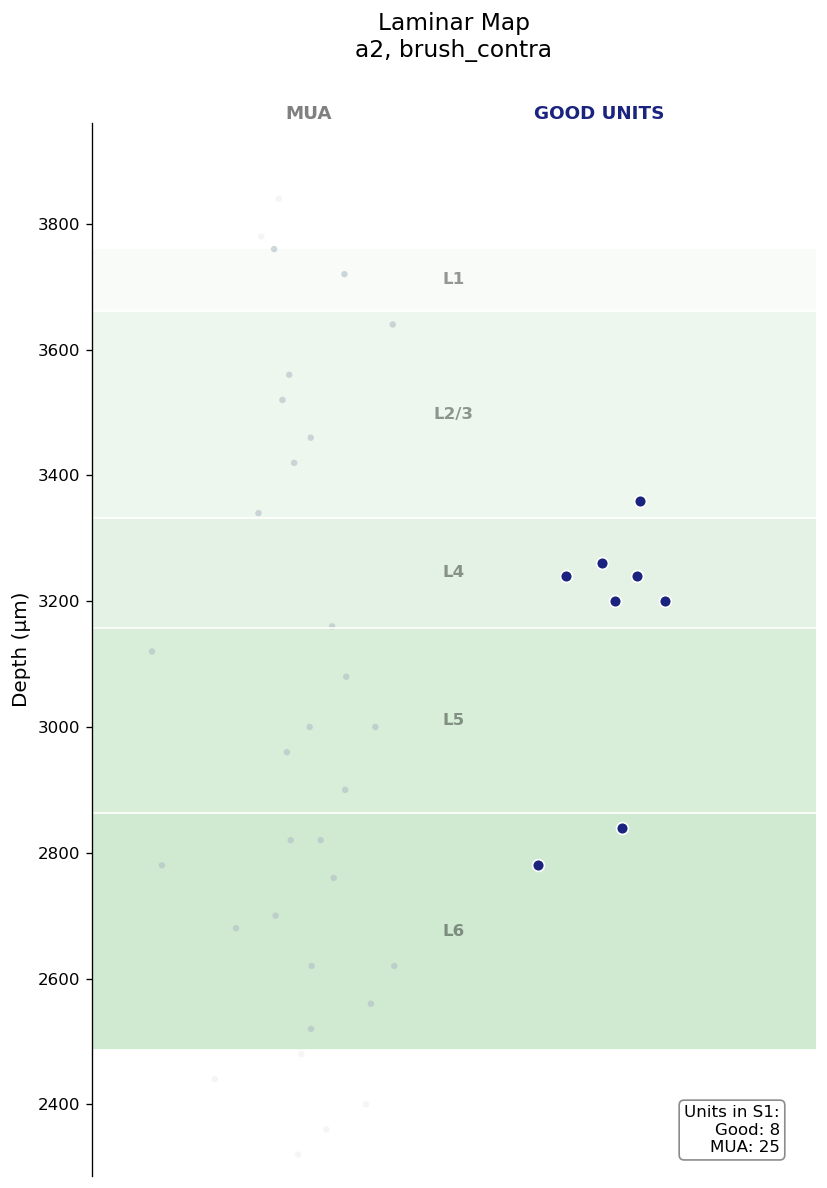

Units in S1: 8 Good Units | 25 MUA


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from scipy import stats

# =========================================================
# 1. CONFIGURATION
# =========================================================
SESSION = "a2"       
STIM = "brush_contra"       
INCLUDE_MUA = True

# Plot settings
PLOT_REAL_X_POSITION = False # <--- Set True to see actual probe columns (0-48um)
JITTER_WIDTH = 0.25          # <--- Now effectively controls the spread width
MARGIN_UM = 200             
FIG_SIZE = (7, 10)          

# Colors
C_GOOD = '#1A237E'          
C_MUA  = '#B0BEC5'          
C_OUT  = '#E0E0E0'          

# =========================================================
# 2. LOAD METADATA
# =========================================================
csv_path = Path("data/sessions.csv")

sessions = pd.read_csv(csv_path, sep=',') 
row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]

if row.empty: raise ValueError(f"❌ Session not found.")
row = row.iloc[0]

phy_dir = Path(row['phy_dir'])
age = str(row['age']).strip()

def get_val(r, col):
    return float(r[col]) if col in r and not pd.isna(r[col]) else np.nan

s1_upper = get_val(row, 's1_upper_um')
s1_lower = get_val(row, 's1_lower_um')

layers = {
    'L1':   get_val(row, 'l1_end'),
    'L2/3': get_val(row, 'l23_end'),
    'L4':   get_val(row, 'l4_end'),
    'L5':   get_val(row, 'l5_end'),
    'L6':   get_val(row, 'l6_end')
}

print(f"✓ Found: {SESSION} (Age: {age})")

# =========================================================
# 3. LOAD DATA
# =========================================================
try:
    channel_positions = np.load(phy_dir / 'channel_positions.npy')
    templates = np.load(phy_dir / 'templates.npy')
    spike_clusters = np.load(phy_dir / 'spike_clusters.npy').flatten()
    spike_templates = np.load(phy_dir / 'spike_templates.npy').flatten()
    
    ks_path = phy_dir / 'cluster_group.tsv'
    if not ks_path.exists(): ks_path = phy_dir / 'cluster_KSLabel.tsv'
    df_ks = pd.read_csv(ks_path, sep='\t')
except FileNotFoundError as e:
    raise e

# =========================================================
# 4. PROCESS UNITS
# =========================================================
label_col = 'KSLabel' if 'KSLabel' in df_ks.columns else 'group'
valid_labels = ['good', 'mua'] if INCLUDE_MUA else ['good']
target_ids = df_ks[df_ks[label_col].isin(valid_labels)]['cluster_id'].values

unit_data = []
view_top = s1_upper + MARGIN_UM if not np.isnan(s1_upper) else 3840
view_bottom = s1_lower - MARGIN_UM if not np.isnan(s1_lower) else 0

for cid in target_ids:
    quality = df_ks[df_ks['cluster_id'] == cid][label_col].values[0]
    mask = spike_clusters == cid
    if not np.any(mask): continue
    
    relevant_templates = spike_templates[mask]
    dominant_template_idx = stats.mode(relevant_templates, keepdims=False)[0]
    temp_waveform = templates[dominant_template_idx]
    peak_channel_idx = np.argmax(np.max(np.abs(temp_waveform), axis=0))
    
    # Get X and Y coordinates from the channel map
    x_um = channel_positions[peak_channel_idx, 0] # Real physical X
    y_um = channel_positions[peak_channel_idx, 1] # Real physical Y (Depth)
    
    if y_um < view_bottom or y_um > view_top: continue

    is_in_s1 = False
    if not np.isnan(s1_upper) and not np.isnan(s1_lower):
        if (y_um >= s1_lower) and (y_um <= s1_upper):
            is_in_s1 = True
            
    unit_data.append({'id': cid, 'depth': y_um, 'x_pos': x_um, 'in_s1': is_in_s1, 'quality': quality})

df_units = pd.DataFrame(unit_data)

# Calculate Stats for Textbox
n_good_s1 = len(df_units[(df_units['quality'] == 'good') & (df_units['in_s1'])])
n_mua_s1 = len(df_units[(df_units['quality'] == 'mua') & (df_units['in_s1'])])

# =========================================================
# 5. VISUALIZATION
# =========================================================
fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=120)

# --- A. Draw Anatomy Background ---
current_top = s1_upper 
layer_colors = {'L1': '#E8F5E9', 'L2/3': '#C8E6C9', 'L4': '#A5D6A7', 'L5': '#81C784', 'L6': '#66BB6A'}

if not np.isnan(s1_upper) and not np.isnan(s1_lower):
    for layer_name in ['L1', 'L2/3', 'L4', 'L5', 'L6']:
        bot = layers[layer_name]
        if not np.isnan(bot):
            ax.axhspan(bot, current_top, color=layer_colors.get(layer_name, 'white'), alpha=0.3, lw=0)
            mid = (current_top + bot) / 2
            # Label in very center
            ax.text(0, mid, layer_name, ha='center', va='center', fontsize=10, 
                    fontweight='bold', color='black', alpha=0.4)
            ax.axhline(bot, color='white', linestyle='-', linewidth=1)
            current_top = bot

# --- B. Plot Data ---
X_MUA_CENTER = -150 if PLOT_REAL_X_POSITION else -0.8
X_GOOD_CENTER = 150 if PLOT_REAL_X_POSITION else 0.8

def get_x_coords(units, center_x):
    if PLOT_REAL_X_POSITION:
        # Use real physical X (0-60um usually), offset to left or right side
        return units['x_pos'].values + center_x
    else:
        # Use Random Jitter based on Config
        return np.random.normal(center_x, JITTER_WIDTH, size=len(units))

# 1. MUA (Left Side)
mua_units = df_units[df_units['quality'] == 'mua']
if len(mua_units) > 0:
    mua_s1 = mua_units[mua_units['in_s1']]
    mua_out = mua_units[~mua_units['in_s1']]
    
    ax.scatter(get_x_coords(mua_s1, X_MUA_CENTER), mua_s1['depth'], 
               s=15, color=C_MUA, alpha=0.6, edgecolors='none', label='MUA (S1)')
    if len(mua_out) > 0:
        ax.scatter(get_x_coords(mua_out, X_MUA_CENTER), mua_out['depth'], 
                   s=15, color=C_OUT, alpha=0.3, edgecolors='none')

# 2. Good Units (Right Side)
good_units = df_units[df_units['quality'] == 'good']
if len(good_units) > 0:
    good_s1 = good_units[good_units['in_s1']]
    good_out = good_units[~good_units['in_s1']]
    
    ax.scatter(get_x_coords(good_s1, X_GOOD_CENTER), good_s1['depth'], 
               s=50, color=C_GOOD, alpha=1.0, edgecolors='white', linewidth=1.0, label='Good (S1)')
    if len(good_out) > 0:
        ax.scatter(get_x_coords(good_out, X_GOOD_CENTER), good_out['depth'], 
                   s=40, color=C_OUT, alpha=0.5, edgecolors='gray', linewidth=0.5)

# --- C. Styling ---
ax.set_ylim(view_bottom, view_top)

if PLOT_REAL_X_POSITION:
    ax.set_xlim(-200, 200) # Physical width in microns (roughly)
    # Remove x-ticks as they are offset
    ax.set_xticks([])
else:
    ax.set_xlim(-2, 2)     # Arbitrary width
    ax.set_xticks([])

# Labels
ax.text(X_MUA_CENTER, view_top, "MUA", ha='center', va='bottom', fontsize=11, fontweight='bold', color='gray')
ax.text(X_GOOD_CENTER, view_top, "GOOD UNITS", ha='center', va='bottom', fontsize=11, fontweight='bold', color=C_GOOD)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)

ax.set_ylabel("Depth (µm)", fontsize=12)
plt.title(f"Laminar Map\n{SESSION}, {STIM}", fontsize=14, pad=40)

# --- D. Stats Textbox ---
stats_text = f"Units in S1:\nGood: {n_good_s1}\nMUA: {n_mua_s1}"
props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
# Place text in bottom right corner (axes coordinates)
ax.text(0.95, 0.02, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()

# --- E. Save Plot ---
output_dir = Path("results/plots")
output_dir.mkdir(parents=True, exist_ok=True)
save_name = output_dir / f"{SESSION}_{STIM}_laminar_map.png"
plt.savefig(save_name, dpi=300, bbox_inches='tight')
print(f"✓ Saved plot to: {save_name}")

plt.show()

print(f"Units in S1: {n_good_s1} Good Units | {n_mua_s1} MUA")

Loading metadata from: data\sessions.csv
✓ Found: a2 (Age: adult)
✓ S1 Range: 2486.0 - 3780.0 µm

Loading spike data... Done.
Mapping 21 'good' units...


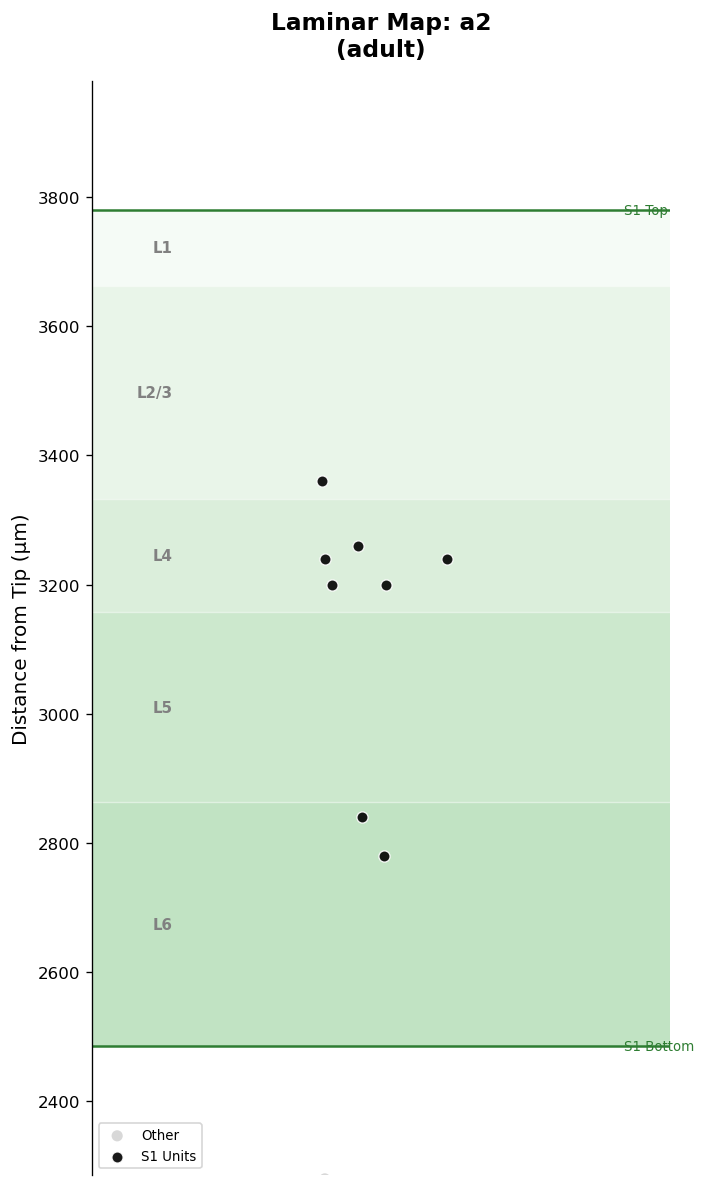


LAMINAR DISTRIBUTION: a2
 Total S1 Units: 8
----------------------------------------
 L1    (3662-3780µm):   0 units
 L2/3  (3333-3662µm):   1 units
 L4    (3157-3333µm):   5 units
 L5    (2863-3157µm):   0 units
 L6    (2486-2863µm):   2 units



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from scipy import stats

# =========================================================
# 1. CONFIGURATION
# =========================================================
SESSION = "a2"       
STIM = "brush_contra"       

# Plot settings
PROBE_HEIGHT_UM = 3840      
JITTER_WIDTH = 0.6          
POINT_SIZE = 45             
FIG_SIZE = (6, 10)          # Made slightly wider for labels

# =========================================================
# 2. LOAD METADATA
# =========================================================
csv_path = Path("data/sessions_local.csv")
if not csv_path.exists():
    csv_path = Path("data/sessions.csv")

print(f"Loading metadata from: {csv_path}")
sessions = pd.read_csv(csv_path, sep=',') 

row = sessions.loc[(sessions['session'].str.lower() == SESSION.lower()) & 
                   (sessions['stim'].str.lower() == STIM.lower())]

if row.empty:
    raise ValueError(f"❌ No row found for session='{SESSION}' and stim='{STIM}'")
row = row.iloc[0]

phy_dir = Path(row['phy_dir'])
age = str(row['age']).strip()

# --- Load Anatomy & Layers ---
# We use a helper function to safely get float values or NaN
def get_val(r, col):
    return float(r[col]) if col in r and not pd.isna(r[col]) else np.nan

s1_upper = get_val(row, 's1_upper_um')
s1_lower = get_val(row, 's1_lower_um')

# Dictionary of Layer Boundaries (The "Bottom" of each layer)
# Expects CSV columns: l1_end, l23_end, l4_end, l5_end, l6_end
layers = {
    'L1':   get_val(row, 'l1_end'),
    'L2/3': get_val(row, 'l23_end'),
    'L4':   get_val(row, 'l4_end'),
    'L5':   get_val(row, 'l5_end'),
    'L6':   get_val(row, 'l6_end')  # Should ideally match s1_lower
}

print(f"✓ Found: {SESSION} (Age: {age})")
print(f"✓ S1 Range: {s1_lower} - {s1_upper} µm")

# =========================================================
# 3. LOAD KILOSORT DATA
# =========================================================
print("\nLoading spike data...", end="")
try:
    channel_positions = np.load(phy_dir / 'channel_positions.npy')
    templates = np.load(phy_dir / 'templates.npy')
    spike_clusters = np.load(phy_dir / 'spike_clusters.npy').flatten()
    spike_templates = np.load(phy_dir / 'spike_templates.npy').flatten()
    
    ks_path = phy_dir / 'cluster_group.tsv'
    if not ks_path.exists(): ks_path = phy_dir / 'cluster_KSLabel.tsv'
    df_ks = pd.read_csv(ks_path, sep='\t')
    print(" Done.")
except FileNotFoundError as e:
    print(f"\n❌ Error loading files in: {phy_dir}")
    raise e

# =========================================================
# 4. PROCESS UNITS
# =========================================================
label_col = 'KSLabel' if 'KSLabel' in df_ks.columns else 'group'
good_ids = df_ks[df_ks[label_col] == 'good']['cluster_id'].values

print(f"Mapping {len(good_ids)} 'good' units...")
unit_data = []

for cid in good_ids:
    mask = spike_clusters == cid
    if not np.any(mask): continue
    
    # Find dominant template
    relevant_templates = spike_templates[mask]
    dominant_template_idx = stats.mode(relevant_templates, keepdims=False)[0]
    
    # Find physical location
    temp_waveform = templates[dominant_template_idx]
    peak_channel_idx = np.argmax(np.max(np.abs(temp_waveform), axis=0))
    depth_um = channel_positions[peak_channel_idx, 1]
    
    # Check S1
    is_in_s1 = False
    if not np.isnan(s1_upper) and not np.isnan(s1_lower):
        if (depth_um >= s1_lower) and (depth_um <= s1_upper):
            is_in_s1 = True
            
    unit_data.append({'id': cid, 'depth': depth_um, 'in_s1': is_in_s1})

df_units = pd.DataFrame(unit_data)
s1_units = df_units[df_units['in_s1'] == True]
other_units = df_units[df_units['in_s1'] == False]

# =========================================================
# 5. GENERATE PRESENTATION PLOT
# =========================================================
plt.figure(figsize=FIG_SIZE, dpi=120)
ax = plt.gca()

# --- A. Draw Layers ---
# We define the "Top" of the current layer as the "Bottom" of the previous one
# Start from the top of S1
current_top = s1_upper 

# Define colors for layers (alternating subtle greens)
layer_colors = {'L1': '#E8F5E9', 'L2/3': '#C8E6C9', 'L4': '#A5D6A7', 'L5': '#81C784', 'L6': '#66BB6A'}
text_colors =  {'L1': 'gray',    'L2/3': 'gray',    'L4': 'gray',   'L5': 'gray',   'L6': 'gray'}

# If S1 bounds exist
if not np.isnan(s1_upper) and not np.isnan(s1_lower):
    
    # Iterate through standard layer order
    for layer_name in ['L1', 'L2/3', 'L4', 'L5', 'L6']:
        layer_bottom = layers[layer_name]
        
        # Draw layer if we have a valid boundary
        if not np.isnan(layer_bottom):
            # Draw Band
            plt.axhspan(layer_bottom, current_top, color=layer_colors.get(layer_name, 'gray'), alpha=0.4, lw=0)
            
            # Label Layer (Centered)
            mid_point = (current_top + layer_bottom) / 2
            plt.text(-1.8, mid_point, layer_name, color=text_colors.get(layer_name, 'black'), 
                     fontsize=9, fontweight='bold', va='center', ha='right')
            
            # Draw Divider Line
            plt.axhline(layer_bottom, color='white', linestyle='-', linewidth=0.8, alpha=0.5)
            
            # Update top for next layer
            current_top = layer_bottom
        else:
            # If a layer is missing in CSV, we stop drawing specifically but keep the outer box
            pass

    # Draw Outer S1 Borders
    plt.axhline(s1_upper, color='#2E7D32', linestyle='-', linewidth=1.5)
    plt.axhline(s1_lower, color='#2E7D32', linestyle='-', linewidth=1.5)
    plt.text(2.1, s1_upper, 'S1 Top', color='#2E7D32', fontsize=8, va='center')
    plt.text(2.1, s1_lower, 'S1 Bottom', color='#2E7D32', fontsize=8, va='center')

# --- B. Plot Units ---
x_jitter_other = np.random.uniform(-JITTER_WIDTH, JITTER_WIDTH, size=len(other_units))
x_jitter_s1 = np.random.uniform(-JITTER_WIDTH, JITTER_WIDTH, size=len(s1_units))

plt.scatter(x_jitter_other, other_units['depth'], alpha=0.3, color='gray', s=POINT_SIZE, edgecolors='none', label='Other')
plt.scatter(x_jitter_s1, s1_units['depth'], alpha=0.9, color='black', s=POINT_SIZE, edgecolors='white', linewidth=0.8, label='S1 Units')

# --- C. Styling ---
if not np.isnan(s1_upper) and not np.isnan(s1_lower):
    view_top = s1_upper + 200
    view_bottom = s1_lower - 200
    plt.ylim(view_bottom, view_top)
else:
    # Fallback if no anatomy defined
    plt.ylim(0, 3840) 
plt.xlim(-2.5, 2.5)               

plt.ylabel("Distance from Tip (µm)", fontsize=12)
plt.title(f"Laminar Map: {SESSION}\n({age})", fontsize=14, fontweight='bold', pad=15)

ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.legend(loc='lower left', frameon=True, fontsize=8)

plt.tight_layout()
plt.show()

# =========================================================
# 6. PRINT SUMMARY
# =========================================================
print("\n" + "="*40)
print(f"LAMINAR DISTRIBUTION: {SESSION}")
print("="*40)
print(f" Total S1 Units: {len(s1_units)}")
print("-" * 40)

# Calculate counts per layer
if not np.isnan(s1_upper):
    current_top = s1_upper
    for layer_name in ['L1', 'L2/3', 'L4', 'L5', 'L6']:
        bot = layers[layer_name]
        if not np.isnan(bot):
            count = len(s1_units[(s1_units['depth'] <= current_top) & (s1_units['depth'] > bot)])
            print(f" {layer_name:5s} ({int(bot)}-{int(current_top)}µm): {count:3d} units")
            current_top = bot
print("="*40 + "\n")